# Jupyter Notebook for defining snow avalanche geometry in DAS data

### TASK: 

Define the space/time extent of a snow-avalanche, as seen by DAS recordings

### Workflow

(1) Read HDF5 file

(2) Prepare/filter signals

(3) Define DAS geometry in UTM and plot it

(4) Select time/space square of interest and transform selected data in energy

(5) Manual picking of P-wave arrivals, start-time and end-time, related to snow avalanche

(6) Run automatic picker (Baer and Kradolfer, 1987) based on energy

(7) Plot (manual/automatic) results as a space-time graph.



### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from obspy.core import read
from obspy.signal.trigger import plot_trigger
from obspy.signal.trigger import pk_baer

import sys
import os
import ftplib 

import h5py

# Interactive sections of the JNotebook
from ipywidgets import interact, Layout
import ipywidgets as widgets


### Define relevant variables/parameters

In [9]:
########## EDIT HERE ########################
#
DAS_PROJ="DAS_BIC_16"            #   DAS_BIC_03  or DAS_BIC_16
LABEL="EXP2"                     #   EXP1 or EXP2
#
########## EDIT HERE ########################



if DAS_PROJ == "DAS_BIC_03":
    DAS_geom_image='./img/background_DAS_BIC_03.png'
    NAME_and_COORD_stations= './info/DAS_BIC_03_cable_geom.dat'
    if LABEL == 'EXP1':
        EVENT_NAME = DAS_PROJ + '_EXPLOSION_01'
        target_datafile = 'DAS_BIC_03__EXPLOSIONS_01_section_0.h5'
    if LABEL == 'EXP2':
        EVENT_NAME = DAS_PROJ + '_EXPLOSION_02'
        target_datafile = 'DAS_BIC_03__EXPLOSIONS_02_section_0.h5'

if DAS_PROJ == "DAS_BIC_16":
    DAS_geom_image='./img/background_DAS_BIC_03.png'
    NAME_and_COORD_stations= './info/DAS_BIC_16_cable_geom.dat'
    if LABEL == 'EXP1':
        EVENT_NAME = DAS_PROJ + '_EXPLOSION_01'
        target_datafile = 'DAS_BIC_16__EXP_01.h5'
    if LABEL == 'EXP2':
        EVENT_NAME = DAS_PROJ + '_EXPLOSION_02'
        target_datafile = 'DAS_BIC_16__EXP_02.h5'


# FTP service
FTP_host = "ftp.ingv.it"
ftp_path = "/pub/nicola.piana/UNIVIE-lectures/"

# Additional variables
saved_file = './input/' + target_datafile      # HDF5 file saved on disk
SpS=500                                        # Samples per second in HDF5 file
Nstack=2                                       # Number of channels in each stack
                                  
print('Working on explosion: ', EVENT_NAME)

Working on explosion:  DAS_BIC_16_EXPLOSION_02


### Define filter

In [10]:
from scipy.signal import butter, sosfilt, sosfreqz

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y


## (1) Read HDF5 file

#### Download HDF5 file from FTP

In [11]:
    
if os.path.exists( saved_file ):
        print('DAS data already donwloaded ... skipping FTP phase')
else:
    ftp = ftplib.FTP(FTP_host) 
    ftp.login() 
    ftp.cwd(ftp_path)
    print('Dowloading file:', target_datafile, ' in file: ', saved_file)
    ftp.retrbinary("RETR " + target_datafile, open(saved_file, 'wb').write)
    print('Dowloading file:', target_datafile, ' completed ...' )
    ftp.quit()


DAS data already donwloaded ... skipping FTP phase


#### Read HDF5 file signature

In [12]:
with h5py.File(saved_file, "r") as f:
    # List all groups
    print("DAS interrogator S/N: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    data = list(f[a_group_key])

DAS interrogator S/N: <KeysViewHDF5 ['fa1-21060065']>


#### Read HDF5 file details

In [13]:

with h5py.File(saved_file, 'r') as f:
    das = np.array(f['fa1-21060065/Source1/Zone1/StrainRate'])
    time_das = np.array(f['fa1-21060065/Source1/time'])
    npts=das.shape[0]
    nch=das.shape[1]
    print('\n INFORMATION ON HDF5 file:\n')
    print('Content: ', list(f['fa1-21060065/Source1/Zone1']))
    print('Number of samples: ', npts)
    print('Number of channels: ', nch)
    print('START EPOCH time:', int(time_das[0]))
    print('END EPOCH time:', int(time_das[time_das.shape[0]-1]))
    



 INFORMATION ON HDF5 file:

Content:  ['StrainRate']
Number of samples:  10013
Number of channels:  1625
START EPOCH time: 1712154817
END EPOCH time: 1712154837


#### Append all channels in matrix (channels in rows, samples in columns)

In [14]:

data_stream = []

print('START Appending channels into a matrix ... ')

istat = 0
while istat < nch: 
    if istat % 100 == 0:
        print('Append channel: ', istat)
    trace = []
    isps = 0
    while isps < npts:
        trace.append(das[isps,istat])
        isps=isps+1
    data_stream.append(trace)
    istat=istat+1
    
print('END Appending channels into a matrix ... ')
       

START Appending channels into a matrix ... 
Append channel:  0
Append channel:  100
Append channel:  200
Append channel:  300
Append channel:  400
Append channel:  500
Append channel:  600
Append channel:  700
Append channel:  800
Append channel:  900
Append channel:  1000
Append channel:  1100
Append channel:  1200
Append channel:  1300
Append channel:  1400
Append channel:  1500
Append channel:  1600
END Appending channels into a matrix ... 


## (2) Prepare/filter signals

#### Apply a filter

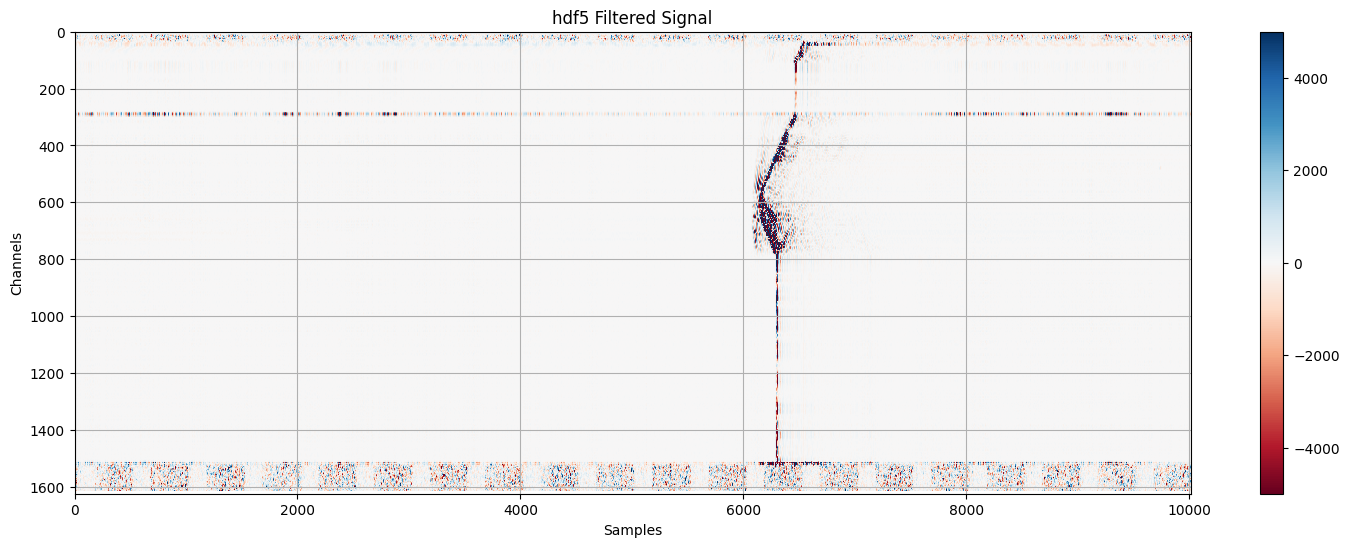

In [ ]:

# FILTER
lowcut = 0.01             # Band-pass Filter Low limit, in Hz 
highcut = 50.0            # Band-pass Filter High limit, in Hz

filt_data = butter_bandpass_filter(data_stream, lowcut, highcut, SpS, order=6) 


#
# Plot filtered signal
#
xmin=0; xmax=npts

plt.figure(figsize=(18,6))
exp_event = plt.imshow(filt_data, cmap="RdBu", vmin=-5000, vmax=5000, aspect='auto',interpolation='nearest')
plt.xlim(xmin,xmax)
plt.ylim(nch,0)
plt.ylabel('Channels')
plt.xlabel('Samples')
plt.grid()
plt.colorbar(exp_event)
plt.title('hdf5 Filtered Signal')
plt.show()


## (3) Define DAS geometry in UTM and plot it


Blue line, actual fiber optic cable, recostructed from TAP TEST


In [ ]:
tap_x_all = []
tap_y_all = []
CHAN = []
ch_x = []
ch_y = []


statfile = open(NAME_and_COORD_stations, 'r')

#
# CABLE
#
linestoken=statfile.readlines()

for x in linestoken:

    CHAN.append(x.split()[0])
    ch_x.append(float(x.split()[1])/1000.0)
    ch_y.append(float(x.split()[2])/1000.0)

    
im = plt.imread("img/background_DAS_BIC_03.png")
plt.figure(figsize=(15.72,10))
xmin, xmax, ymin, ymax = (582.82, 584.16, 5230.8, 5231.5)
aspect = im.shape[0] / im.shape[1] * (xmax - xmin)/(ymax - ymin)
plt.imshow(im, zorder=0, extent=[xmin, xmax, ymin, ymax], aspect=aspect)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.plot(ch_x, ch_y, '-', markersize=4, color='blue',label="Fiber optic cable")
plt.legend(title='Channels:', bbox_to_anchor=(0.80, 0.95), loc='upper left',)
plt.xlabel("UTM-X (km)", fontsize=24)
plt.ylabel("UTM-Y (km)",fontsize=24)
plt.show()


## (3) Define data-window (where the snow avalanche is present in time and space)

In [ ]:

file_path1 = './output/' + EVENT_NAME + '.data_window'

if os.path.exists(file_path1):
    print('\n File: ', file_path1, 'exists and will be overwritten')
    




@interact(X=widgets.IntRangeSlider(value=[0, npts], min=0,max=npts, step=1, description='TIME',
                                        continuous_update=False, layout=Layout(width='90%', height='30px')),
          Y=widgets.IntRangeSlider(value=[0, nch], min=0,max=nch, step=1, description='SPACE',
                                        continuous_update=False, layout=Layout(width='90%', height='30px')),
          Save=False)
    
def npa_picking(X, Y, Save):
    
    
    #
    # Plot window-ed signal
    #
    
    xmin=X[0]; xmax=X[1]
    ymin=Y[0]; ymax=Y[1]

    plt.figure(figsize=(18,6))
    exp_event = plt.imshow(filt_data, cmap="RdBu", vmin=-5000, vmax=5000, aspect='auto',interpolation='nearest')
    plt.xlim(xmin,xmax)
    plt.ylim(ymax,ymin)
    plt.ylabel('Channels')
    plt.xlabel('Samples')
    plt.grid()
    plt.colorbar(exp_event)
    plt.title('hdf5 WINDOW-ed Signal')
    plt.show()
    
    print('WINDOW DATA in SAMPLES and CHANNELS:', X[0],X[1],Y[0],Y[1])
    if Save == True:
        print('\nWriting TIME-SPACE window for data-analysis ')
        windowfile=open(file_path1,'w')
        windowfile.write('%12d%12d%6d%6d' % (X[0],X[1],Y[0],Y[1]))  
        windowfile.close
    plt.figure()
        
   



## (3) Manual picking of START-time and END-time for selected channels

In [ ]:
file_path2 = './output/' + EVENT_NAME + '.avalanche_manual_picking'

if os.path.exists(file_path2):
    print('\n File: ', file_path2, 'exists. New data will be appended')
else:
    pick_file=open(file_path2,'w')
    pick_file.close
    
    
#
# Read most promising window
#
file_path1 = './output/' + EVENT_NAME + '.data_window'
ff=open(file_path1,'r')
linestoken=ff.readlines()
for x in linestoken:
    START_SAMPLE=int(x.split()[0])
    END_SAMPLE=int(x.split()[1])
    START_CH=int(x.split()[2])
    END_CH=int(x.split()[3])

        
data = filt_data.T

tr0 = []
t = []
t1=np.arange(0,(1/SpS)*npts,1/SpS) 


IN_STAT=input('\n Seleziona un canale [' + str(START_CH) + '-' + str(END_CH) + ']:')
istat=int(IN_STAT)

#
# Stacking channels
#

j0 = istat
#print('\n Starting trace:', j0)
ntr = 1
    
s1 = data[:,j0]
j = 1
while j < Nstack:
    ntr += 1
    #print('Adding trace:', j0+j)
    s0 = data[:,j0+j]
    # s0 = data_stream[0].traces[j0+j].data   # Format SEGY
    s = np.add(s1,s0)  
    s1 = np.copy(s)
    j += 1

#print('Number of traces in stack:',ntr)
tr0 = (1/ntr) * s1 

stat0=IN_STAT
istat0=int(IN_STAT)
amp=tr0

print('Selected channel:', stat0)


@interact(Pwave=widgets.FloatSlider(min=0.01, max=50.0, step=0.01, value=10.0, description='START',
                                        continuous_update=False, layout=Layout(width='90%', height='30px')), 
          ENDwave=widgets.FloatSlider(min=0.01, max=50.0, step=0.01, value=20.0, description='END',
                                        continuous_update=False, layout=Layout(width='90%', height='30px')),
          X=widgets.FloatRangeSlider(value=[0, 50.0], min=0,max=50.0, step=0.01, description='ZOOM',
                                        continuous_update=False, layout=Layout(width='90%', height='30px')),
          Save=False)
    
def npa_picking(Pwave, ENDwave, X, Save):
    
    x_0=int(X[0]*SpS)
    x_1=int(X[1]*SpS)
    t_plot = []
    tr0_0_plot = []
    t_plot = t1[x_0:x_1]
    tr0_plot=tr0[x_0:x_1]
    
    plt.figure(figsize=(18,3))
    plt.plot(t_plot,tr0_plot)
    plt.grid()
    plt.ylabel('Strain-rate')
    plt.xlabel('Time (s)')
    plt.title('DAS channel:' + stat0)
    plt.xlim(X[0],X[1])
    plt.axvline(x=Pwave, ymin=0.10, ymax=0.90,linewidth=4, color='r')
    plt.axvline(x=ENDwave, ymin=0.10, ymax=0.90,linewidth=4, color='b')
    print('Seismic channel:', stat0, 'P-onset time and END-OF-EVENT time:',Pwave,ENDwave)
    if Save == True:
        Pwave_pick=Pwave
        ENDwave_pick=ENDwave
        print('\nWriting selected P-wave onset and END-OF-EVENT for station: ' + stat0)
        pick_file=open(file_path2,'a')
        pick_file.write('%20.4f%20.4f%6s\n' % (Pwave_pick, ENDwave_pick, stat0))  
        pick_file.close
    plt.figure()
        
   


    


### Results from Manual picking

In [ ]:
#
# Read most promising window
#
file_path1 = './output/' + EVENT_NAME + '.data_window'
ff=open(file_path1,'r')
linestoken=ff.readlines()
for x in linestoken:
    START_SAMPLE=int(x.split()[0])
    END_SAMPLE=int(x.split()[1])
    START_CH=int(x.split()[2])
    END_CH=int(x.split()[3])
#
# Read manual picking
#
START_SAMPLE_all = []
END_SAMPLE_all = []
CH_all = []
file_path2 = './output/' + EVENT_NAME + '.avalanche_manual_picking'
f=open(file_path2,'r')
linestoken=f.readlines()
for x in linestoken:
    START_SAMPLE_all.append(int(SpS*float(x.split()[0])))
    END_SAMPLE_all.append(int(SpS*float(x.split()[1])))
    CH_all.append(int(x.split()[2]))
    
xmin=START_SAMPLE; xmax=END_SAMPLE
ymin=START_CH; ymax=END_CH


fig, (ax1) = plt.subplots(1,figsize=(18,10))
exp_event = plt.imshow(filt_data, cmap="RdBu", vmin=-5000, vmax=5000, aspect='auto',interpolation='nearest')
plt.xlim(xmin,xmax)
plt.ylim(ymax,ymin)
plt.ylabel('Channels')
plt.xlabel('Samples')
plt.colorbar(exp_event,ax=ax1)
plt.plot(START_SAMPLE_all, CH_all, '.', markersize=10, color='red',label="START")
plt.plot(END_SAMPLE_all, CH_all, '.', markersize=10, color='green',label="END")

ax1.set_title('hdf5 WINDOW-ed signal with MANUAL picking')

plt.show()

## (3) Automatic P-wave picking using Baer's approach


To define arrival time for the P-wave of the explosion, we apply a triggering algorithm called "Baer's method"  which is based on a complex Characteristic Function (CF), different from the STA/LTA method (in STA/LTA application the CF is the signal variance).

REFERENCE:

M. Baer and U. Kradolfer, “An Automatic Phase Picker for Local and Teleseismic Events,” Bulletin of the Seismological Society of America, Vol. 77, No. 4, 1987, pp. 1437-1445.

In [ ]:
#
# Open file for writing picking values
pickfile = './output/' + EVENT_NAME + '.avalanche_automatic_picking'

if os.path.exists(pickfile):
    print('\n File: ', pickfile, 'exists and will be overwritten')
    

pick_file=open(pickfile,'w')
n_ch_used=0
 
    
file_path1 = './output/' + EVENT_NAME + '.data_window'
f=open(file_path1,'r')
linestoken=f.readlines()
for x in linestoken:
    START_SAMPLE=int(x.split()[0])
    END_SAMPLE=int(x.split()[1])
    START_CH=int(x.split()[2])
    END_CH=int(x.split()[3])
    
print('\n Automatic picking within pre-defined time-space window: ')
print(' TIME (in samples): ', START_SAMPLE, END_SAMPLE)
print(' SPACE (in channels): ', START_CH, END_CH)


MIN_P_ACCEPTED=float(START_SAMPLE/SpS)
MIN_P_VALIDATED=float(START_SAMPLE/SpS)
MAX_P_VALIDATED=float(END_SAMPLE/SpS)
    

data = filt_data.T

istat=0  # index i counts selected stations

s1 = []
START_pick = []
END_pick = []
CH_sele = []

ich = START_CH
while ich < END_CH:
    
    
    #
    # START AVALANCHE
    #
    
    s1 = data[:,ich]
        
    #Apply BAUER picking
    s1_sele = []

    df = SpS
    istart=START_SAMPLE
    iend=END_SAMPLE 
    s1_sele=s1[istart:iend]
    start_pick, phase_info = pk_baer(s1_sele, df, 20, 60, 7.0, 12.0, 100, 100)
    
    start_pick=start_pick/SpS + MIN_P_ACCEPTED
    
    #
    # END AVALANCHE
    #
    
    s1 = data[:,ich]
        
    #Apply BAUER picking
    s1_sele = []

    df = SpS
    istart=START_SAMPLE
    iend=END_SAMPLE
    isamp=iend
    while isamp>istart:
        s1_sele.append(s1[isamp])
        isamp-=1
    end_pick, phase_info = pk_baer(s1_sele, df, 20, 60, 7.0, 12.0, 100, 100)
    end_pick= MAX_P_VALIDATED - end_pick/SpS
    
    
    pick_file.write('%20.4f%20.4f%6d\n' % (start_pick, end_pick, ich)) 
    print('%10s%20.4f%20.4f%s%6d' % ('PICK START-END:',start_pick,end_pick, ' CH: ', ich))
    START_pick.append(start_pick)
    END_pick.append(end_pick)
    CH_sele.append(ich)


    ich += 1
    
    
    
     
pick_file.flush()

In [ ]:

START_sample0 = np.array(START_pick)
START_sample0 = START_sample0 * SpS

END_sample0 = np.array(END_pick)
END_sample0 = END_sample0 * SpS


xmin=START_SAMPLE; xmax=END_SAMPLE
ymin=START_CH; ymax=END_CH

fig, (ax1) = plt.subplots(1,figsize=(18,10))
exp_event = plt.imshow(filt_data, cmap="RdBu", vmin=-5000, vmax=5000, aspect='auto',interpolation='nearest')
plt.xlim(xmin,xmax)
plt.ylim(ymax,ymin)
plt.ylabel('Channels')
plt.xlabel('Samples')
plt.colorbar(exp_event,ax=ax1)
plt.plot(START_sample0, CH_sele, '.', markersize=4, color='red',label="observed START")
plt.plot(END_sample0, CH_sele, '.', markersize=4, color='green',label="observed END")
ax1.set_title('hdf5 Filtered signal WITH AUTOMATIC PICKING w/ Baer approach')

plt.show()

In [ ]:
%load_ext watermark
%watermark -v -p numpy,matplotlib,obspy,ipywidgets,h5py,h5pyd,scipy,ftplib